In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32
IMG_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plant-diseases",
    shuffle = True,
    batch_size = BATCH_SIZE
)

Found 2882 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

In [7]:
len(dataset)

91

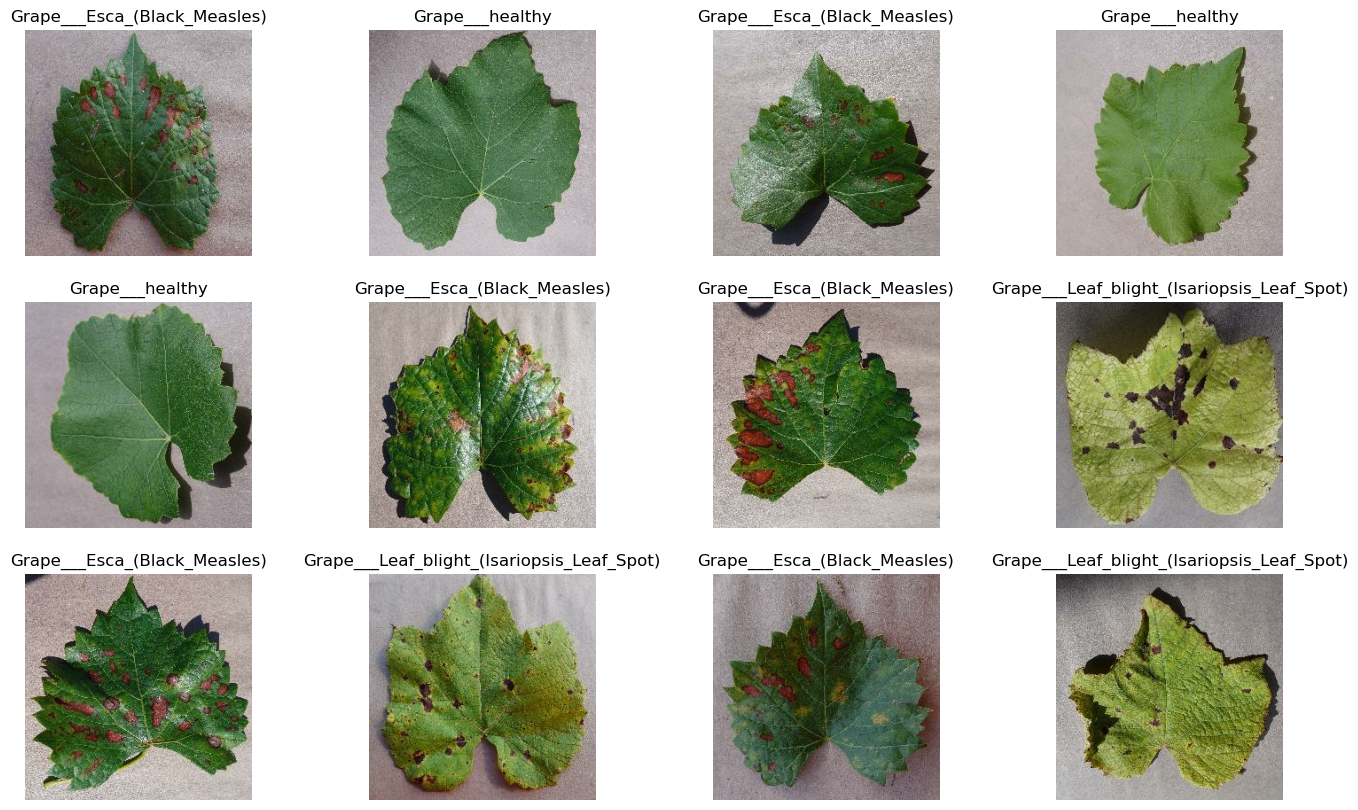

In [8]:
plt.figure(figsize=(17,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [9]:
def get_dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
    
    if shuffle:
        ds.shuffle(shuffle_size, seed=9)
    
    ds_size = len(ds)
    train_size  = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax")
])


model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [16]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [17]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/20


72/72 [==============================] - 60s 733ms/step - loss: 0.7259 - accuracy: 0.6484 - val_loss: 0.8146 - val_accuracy: 0.6736
Epoch 2/20
72/72 [==============================] - 51s 713ms/step - loss: 0.3047 - accuracy: 0.8872 - val_loss: 1.4999 - val_accuracy: 0.6840
Epoch 3/20
72/72 [==============================] - 49s 687ms/step - loss: 0.2594 - accuracy: 0.9119 - val_loss: 0.1825 - val_accuracy: 0.9271
Epoch 4/20
72/72 [==============================] - 47s 657ms/step - loss: 0.1404 - accuracy: 0.9470 - val_loss: 0.2363 - val_accuracy: 0.9028
Epoch 5/20
72/72 [==============================] - 52s 728ms/step - loss: 0.1382 - accuracy: 0.9514 - val_loss: 0.2602 - val_accuracy: 0.8958
Epoch 6/20
72/72 [==============================] - 53s 735ms/step - loss: 0.0732 - accuracy: 0.9705 - val_loss: 0.0451 - val_accuracy: 0.9792
Epoch 7/20
72/72 [==============================] - 52s 720ms/step - loss: 0.0566 - accuracy: 0.9774 - val_loss: 0.1906 - val_accuracy: 0.91

In [18]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 72}

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

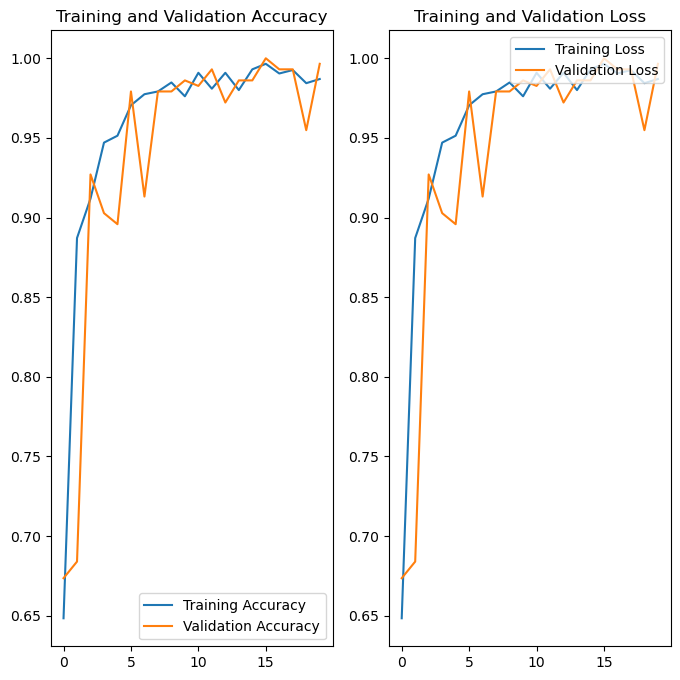

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20), acc, label = "Training Accuracy")
plt.plot(range(20), val_acc, label = "Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(20), acc, label = "Training Loss")
plt.plot(range(20), val_acc, label = "Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


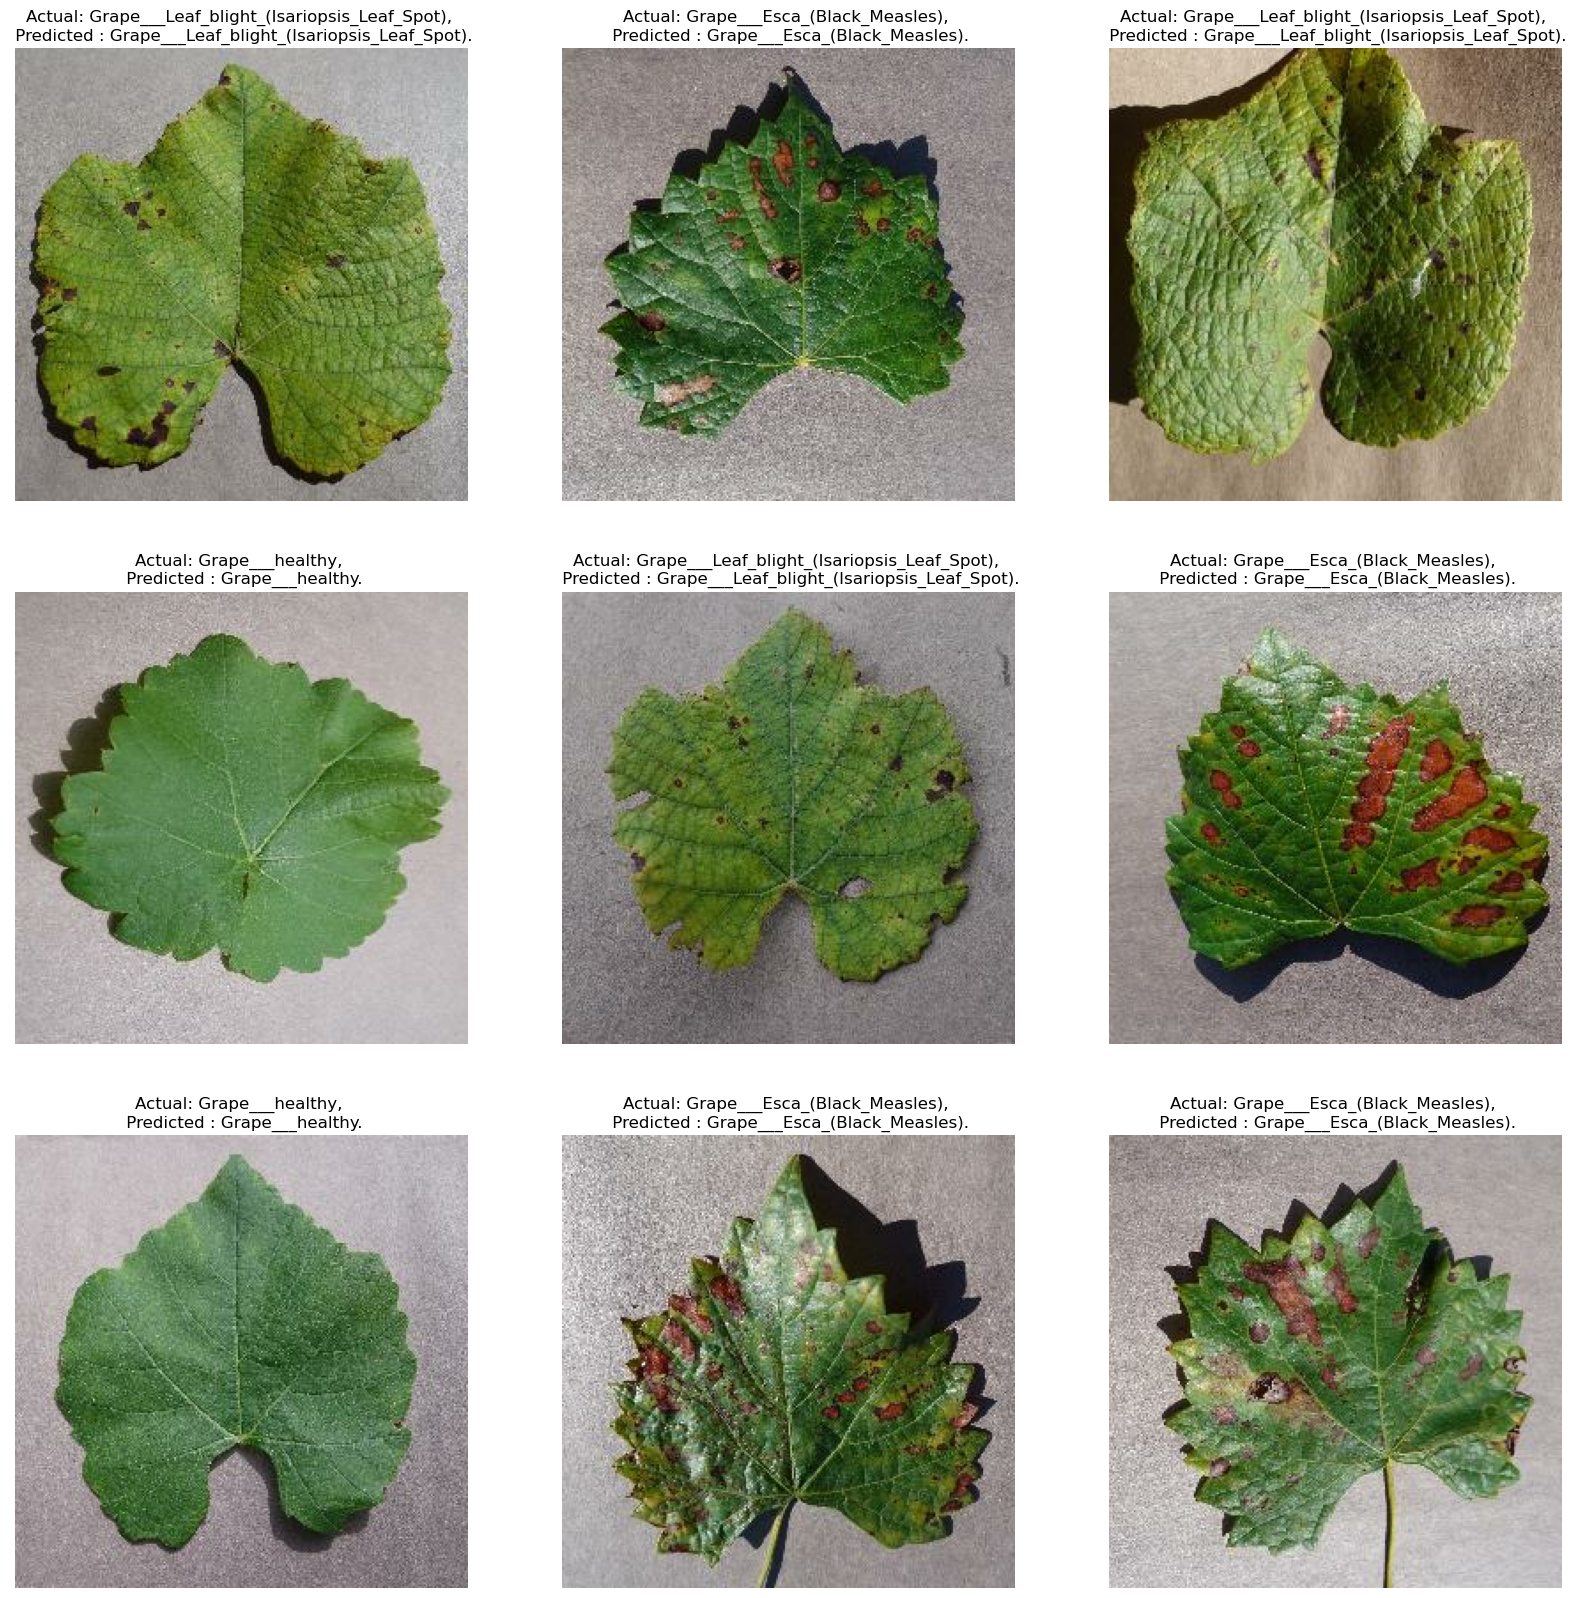

In [36]:
import numpy as np

plt.figure(figsize=(20,20))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted : {predicted_class}.")
        
        plt.axis("off")
        